In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [3]:
#other useful imports we've seen before

import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats

In [4]:
#ok let's load the data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

## Single Neuron Correlations

In [5]:
"""
We're interested in correlations of neural data with potential behavioral outputs. 
So, for example, let's say wanted to use neurons to predict the horizontal position of the 
object in the image -- that is, the "translation_y" field of the image metadata. 
""";

In [6]:
#first let's load the y-position data
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
ypos = Ventral_Dataset['image_meta']['translation_y'][:] 

In [7]:
corr_ypos = np.array([stats.pearsonr(Neural_Data[:, i], ypos)[0] 
                      for i in range(Neural_Data.shape[1])])

In [8]:
corr_ypos.shape

(296,)

(array([   1.,    1.,    0.,   13.,   26.,   37.,   76.,  103.,   31.,    8.]),
 array([-0.34031283, -0.29392473, -0.24753662, -0.20114851, -0.15476041,
        -0.1083723 , -0.06198419, -0.01559609,  0.03079202,  0.07718012,
         0.12356823]),
 <a list of 10 Patch objects>)

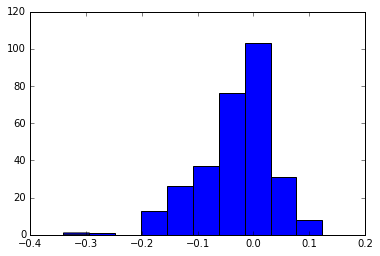

In [9]:
plt.hist(corr_ypos)

(array([ 136.,   74.,   39.,   22.,   14.,    9.,    0.,    0.,    1.,    1.]),
 array([  9.56686029e-06,   3.40398933e-02,   6.80702198e-02,
          1.02100546e-01,   1.36130873e-01,   1.70161199e-01,
          2.04191526e-01,   2.38221852e-01,   2.72252179e-01,
          3.06282505e-01,   3.40312831e-01]),
 <a list of 10 Patch objects>)

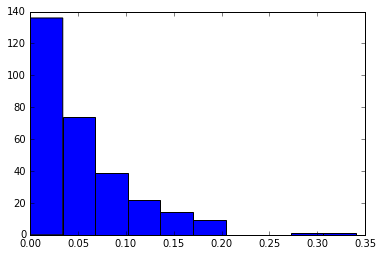

In [10]:
abs_corr_ypos = np.abs(corr_ypos)
plt.hist(abs_corr_ypos)

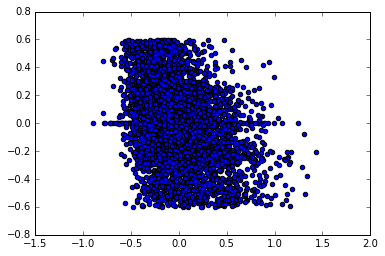

In [11]:
best_ind = most_corred = abs_corr_ypos.argmax()
most_corred_resp = Neural_Data[:, best_ind]
plt.scatter(most_corred_resp , ypos)

In [12]:
category = Ventral_Dataset['image_meta']['category'][:]
var_level = Ventral_Dataset['image_meta']['variation_level'][:]

v0v3 = ((var_level == 'V0') | (var_level == 'V3'))
face_or_car = ((category == 'Faces') | (category == 'Cars'))

subset_inds = v0v3 & face_or_car

Neural_Data_subset = Neural_Data[subset_inds]
category_subset = (category[subset_inds] == 'Faces')

(array([  8.,  21.,  35.,  52.,  50.,  57.,  24.,  23.,  18.,   8.]),
 array([-0.72450253, -0.57719709, -0.42989166, -0.28258622, -0.13528078,
         0.01202465,  0.15933009,  0.30663552,  0.45394096,  0.6012464 ,
         0.74855183]),
 <a list of 10 Patch objects>)

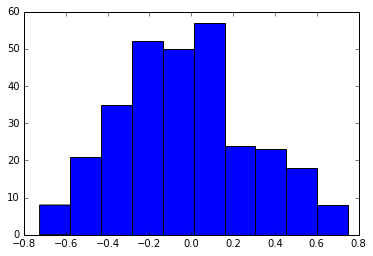

In [13]:
corr_face_vs_car = np.array([stats.pearsonr(Neural_Data_subset[:, i], category_subset)[0] 
                      for i in range(Neural_Data.shape[1])])

plt.hist(corr_face_vs_car)

In [14]:
neurons_sorted_by_facevscar_abscorrelation = np.abs(corr_face_vs_car).argsort()
best_ind_facevscar = neurons_sorted_by_facevscar_abscorrelation[-1]

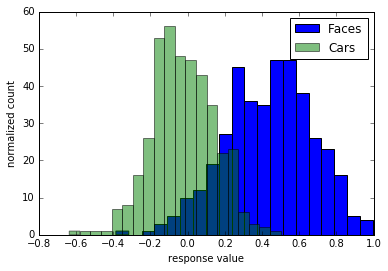

In [15]:
def hist_plot(resp, target_inds, target, nottarget):
    responses_on_target = resp[target_inds]
    responses_on_nottarget = resp[np.invert(target_inds)]
    l0 = plt.hist(responses_on_target, bins=20);
    l1 = plt.hist(responses_on_nottarget, bins=20, alpha=0.5);
    plt.legend([l0[2][0], l1[2][0]], [target, nottarget])
    plt.xlabel('response value')
    plt.ylabel('normalized count')

most_corred_resp = Neural_Data_subset[:, best_ind_facevscar]
hist_plot(most_corred_resp, category_subset, 'Faces', 'Cars')


In [16]:
def percent_correct(predicted, actual):
    correct = (predicted == actual).sum()
    total = len(actual)
    return correct / float(total)

In [17]:
threshold = .2
predicted_face = most_corred_resp > threshold
acc = percent_correct(predicted_face, category_subset)
print('The percent correct is %.2f%%' % (acc * 100)) 

The percent correct is 87.38%


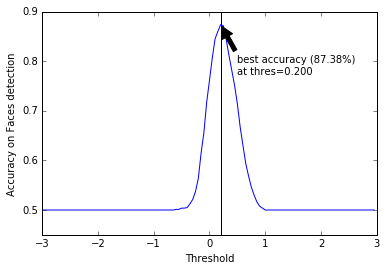

In [18]:
def plot_threshold_acc(resp, categories, target):
    threshold_series = np.arange(-3, 3, .05)
    pcs = [percent_correct(resp > t, categories) 
                        for t in threshold_series]
    best_thres_ind = np.argmax(pcs)
    best_thres = threshold_series[best_thres_ind]
    best_acc = pcs[best_thres_ind]
    plt.plot(threshold_series, pcs)
    plt.axvline(best_thres, color='k')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy on %s detection' % target)
    plt.annotate('best accuracy (%.2f%%)\nat thres=%.3f' % (best_acc * 100, best_thres),
                 xy=(best_thres, best_acc), 
                 xytext=(best_thres + .3, best_acc - .1),
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
    
plot_threshold_acc(most_corred_resp, category_subset, 'Faces')

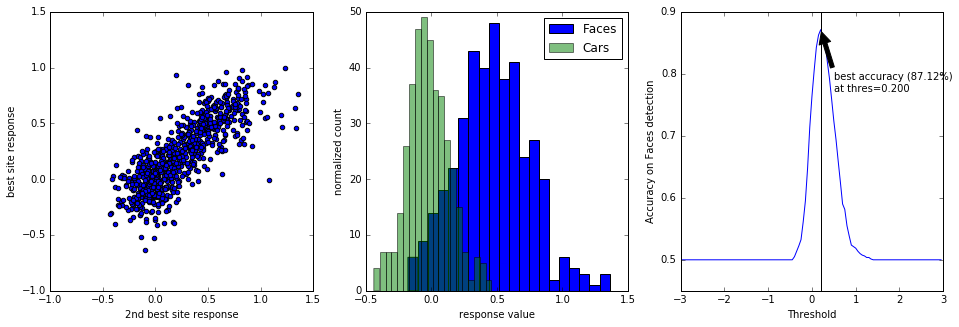

In [21]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
secondbest_ind_facevscar = neurons_sorted_by_facevscar_abscorrelation[-2]
secondmost_corred_resp = Neural_Data_subset[:, secondbest_ind_facevscar]
plt.scatter(secondmost_corred_resp, most_corred_resp)
plt.xlabel('2nd best site response')
plt.ylabel('best site response')

plt.subplot(1, 3, 2)
hist_plot(secondmost_corred_resp, category_subset, 'Faces', 'Cars')

plt.subplot(1, 3, 3)
plot_threshold_acc(secondmost_corred_resp, category_subset, 'Faces')

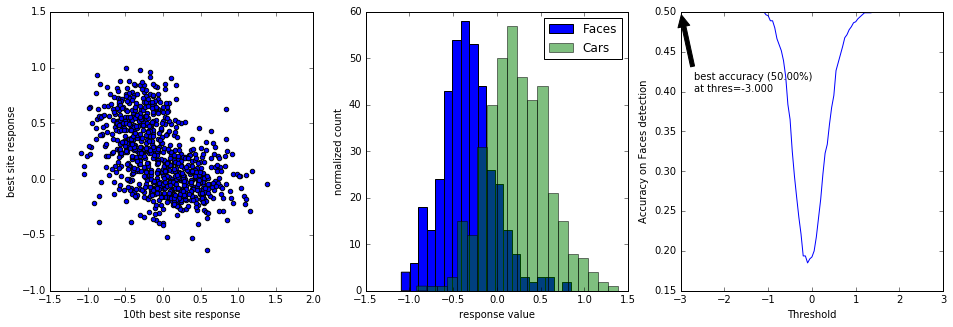

In [22]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
tenthbest_ind = neurons_sorted_by_facevscar_abscorrelation[-10]
tenthmost_corred_resp = Neural_Data_subset[:, tenthbest_ind]
plt.scatter(tenthmost_corred_resp, most_corred_resp)
plt.xlabel('10th best site response')
plt.ylabel('best site response')

plt.subplot(1, 3, 2)
hist_plot(tenthmost_corred_resp, category_subset, 'Faces', 'Cars')

plt.subplot(1, 3, 3)
plot_threshold_acc(tenthmost_corred_resp, category_subset, 'Faces')



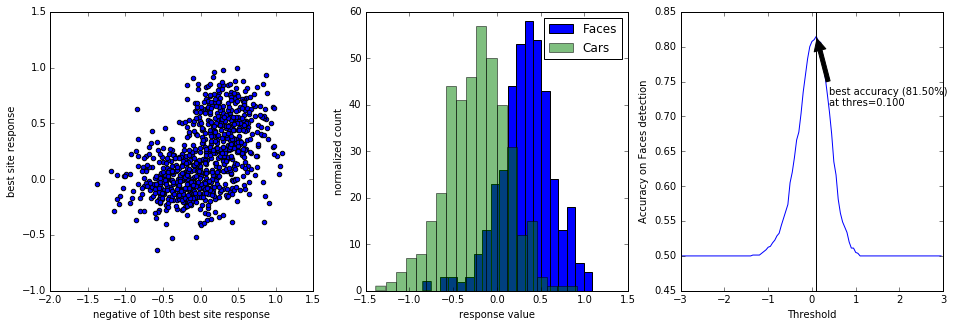

In [23]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
tenthbest_ind = neurons_sorted_by_facevscar_abscorrelation[-10]
tenthmost_corred_resp = -Neural_Data_subset[:, tenthbest_ind]
plt.scatter(tenthmost_corred_resp, most_corred_resp)
plt.xlabel('negative of 10th best site response')
plt.ylabel('best site response')

plt.subplot(1, 3, 2)
hist_plot(tenthmost_corred_resp, category_subset, 'Faces', 'Cars')

plt.subplot(1, 3, 3)
plot_threshold_acc(tenthmost_corred_resp, category_subset, 'Faces')



In [24]:
category = Ventral_Dataset['image_meta']['category'][:]
var_level = Ventral_Dataset['image_meta']['variation_level'][:]
v0v3_inds = ((var_level == 'V0') | (var_level == 'V3'))
Neural_Data_v0v3 = Neural_Data[v0v3_inds]
category_v0v3 = category[v0v3_inds]
face_or_not_v0v3 = (category_v0v3 == 'Faces')


(array([ 24.,  54.,  51.,  58.,  46.,  23.,  22.,   8.,   3.,   7.]),
 array([-0.34607046, -0.24164435, -0.13721824, -0.03279213,  0.07163398,
         0.17606009,  0.2804862 ,  0.38491231,  0.48933842,  0.59376453,
         0.69819064]),
 <a list of 10 Patch objects>)

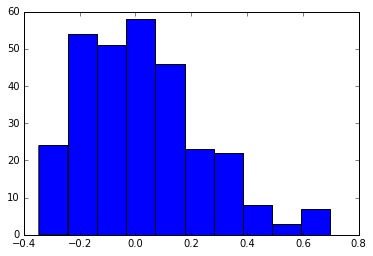

In [25]:
corr_facevsnot = np.array([stats.pearsonr(Neural_Data_v0v3[:, i], face_or_not_v0v3)[0] 
                      for i in range(Neural_Data_v0v3.shape[1])])
plt.hist(corr_facevsnot)

In [26]:
neurons_sorted_by_facevsnot_abscorrelation = np.abs(corr_facevsnot).argsort()

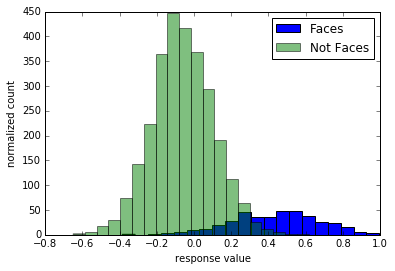

In [27]:
best_ind_facevsnot = neurons_sorted_by_facevscar_abscorrelation[-1]
most_corred_resp = Neural_Data_v0v3[:, best_ind_facevsnot]
hist_plot(most_corred_resp, face_or_not_v0v3, 'Faces', 'Not Faces')

In [28]:
threshold = .2
predicted_face = most_corred_resp > threshold
acc = percent_correct(predicted_face, face_or_not_v0v3)
print('The percent correct is %.2f%%' % (acc * 100)) 

The percent correct is 93.16%


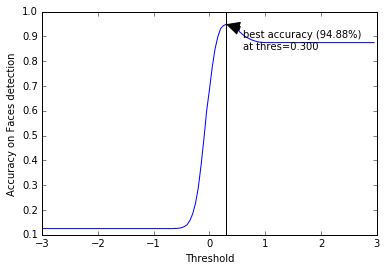

In [29]:
plot_threshold_acc(most_corred_resp, face_or_not_v0v3, 'Faces')

## Minimum Distance and Maximum Correlation Classifiers

In [30]:
#ok So let's work with all 8 categories
categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)


In [31]:
#Now, the core idea of the minimum distance classifier is to 
#   look at distances to means of (neural) features for each category
#   so let's compute the neural feature means for the 8 categories here
category_means = np.array([Neural_Data_v0v3[category_v0v3 == c].mean(0)
                           for c in unique_categories])

In [32]:
#As expected, this is an array with shape (num_categories, num_neurons)
category_means.shape

(8, 296)

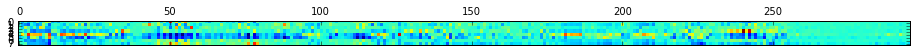

In [33]:
#let's visualize it
plt.matshow(category_means)

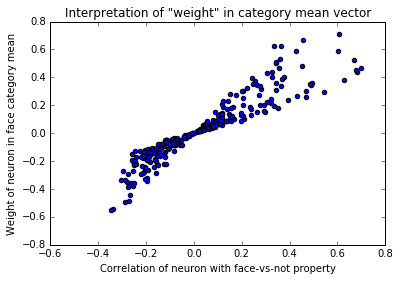

In [94]:
plt.scatter(corr_facevsnot, category_means[4])
plt.xlabel('Correlation of neuron with face-vs-not property')
plt.ylabel('Weight of neuron in face category mean')
plt.title('Interpretation of "weight" in category mean vector')

In [34]:
def distance_classifier(x, means, ucats):
    """Arguments:
         x = new example of data -- of shape N (where N = number of neurons)
         means = matrix of means of each neuron for each category, 
                 of shape (M, N), where M = number of categories
         ucats = vector of category labels (of length M)
       Returns: prediction for x based on minimum distance to category means
    """
    #compute the distances between x and each mean
    distances = ((x - means)**2).sum(1)  #this is a length M vector
    #find the index of the category with the smallest distance
    predicted_category_ind = distances.argmin()    
    #get the category corresponding to that index
    predicted_category = ucats[predicted_category_ind]
    return predicted_category

In [35]:
carface_category_means = category_means[[2, 4]]  #since Cars and Faces were the 2nd and 4th categories, respecitvely
predictions = []
#loop over the neural responses to each stimulus
for resp in Neural_Data_subset:
    #get the predictions for each stimulus
    pred = distance_classifier(resp, 
                               carface_category_means, 
                               ['Cars', 'Faces'])
    #add to the list of predictions
    predictions.append(pred)
#make it a numpy array
predictions = np.array(predictions)

#see how accurate the predictions are
pct = percent_correct(predictions, category[subset_inds])

print('Distance classifier accuracy on Cars / Faces (V0/V3): %.2f%%' % (100*pct))

#ok, so this population classifier is slightly better than what we measured for 
#the best single neuron before (which was <88%)

Distance classifier accuracy on Cars / Faces (V0/V3): 90.88%


In [36]:
def get_confusion_matrix(predicted, actual, ucats):
    """Gets confusion matrix where 
           mat[i, j] = number of instances where 
                 actual = category i and 
                 predicted = category j
    """
    cmat = []
    for a_cat in ucats:
        cvec = []
        for p_cat in ucats:
            rate = ((predicted == p_cat) & (actual == a_cat)).sum()
            cvec.append(rate)
        cmat.append(cvec)
    return np.array(cmat)

def visualize_confmat(cmat, ucats, fig=None):
    cmat = cmat.astype(float) / cmat.sum(0)
    if fig is None:
        plt.matshow(cmat)
    else:
        fig.gca().matshow(cmat)
    for i in range(cmat.shape[0]):
        for j in range(cmat.shape[1]):
            plt.text(j-.1, i, '%.2f%%' % (cmat[i, j] * 100), color='w')
    M = len(ucats)
    plt.xticks(np.arange(M), ucats)
    plt.yticks(np.arange(M), ucats)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

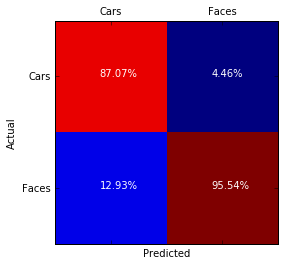

In [37]:
cmat = get_confusion_matrix(predictions, 
                     category[subset_inds], 
                     ['Cars', 'Faces'])
visualize_confmat(cmat, ['Cars', 'Faces'])

In [95]:
#But now we can do the same for 8-way classification
predictions = np.array([distance_classifier(resp, 
                                           category_means,
                                           unique_categories)
                          for resp in Neural_Data_v0v3])

pct = percent_correct(predictions, category_v0v3)

print('Distance classifier accuracy on 8-way classification (V0/V3): %.2f%%' % (100*pct))

#this is way above chance -- recall, chance is 1/8 = 12.5% for this 8-way task

Distance classifier accuracy on 8-way classification (V0/V3): 62.28%


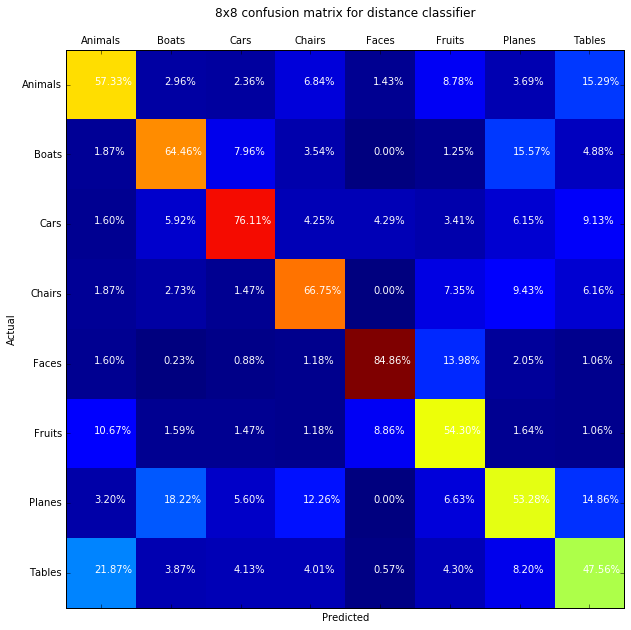

In [96]:
#let's have a look at the 8x8 confusion matrix
cmat = get_confusion_matrix(predictions, 
                            category_v0v3, 
                            unique_categories)
fig = plt.figure(figsize=(10, 10))
visualize_confmat(cmat, unique_categories, fig=fig)
plt.title('8x8 confusion matrix for distance classifier')

In [40]:
def correlation_classifier(x, means, ucats):
    """Arguments:
         x = new example of data -- of shape N (where N = number of neurons)
         means = matrix of means of each neuron for each category, 
                 of shape (M, N), where M = number of categories
         ucats = vector of category labels (of length M)
       Returns: prediction for x based on maximum correlation with category means
    """
    #get the correlations
    correlations = [stats.pearsonr(x, m)[0] for m in means]
    #find the index with highest correlation
    predicted_category_ind = np.argmax(correlations)
    #get the category with that index
    predicted_category = ucats[predicted_category_ind]
    return predicted_category

In [41]:
#let's test our correlation classifier on the same car/face binary classification from above
prediction = [correlation_classifier(resp, 
                                     carface_category_means,
                                     ['Cars', 'Faces'])
                        for resp in Neural_Data_subset]
pct = percent_correct(prediction, category[subset_inds])

print('Correlation classifier accuracy on Cars / Faces (V0/V3): %.2f%%' % (100*pct))

#ok, so this population classifier is in turn slightly better than the distance
#classifier (which was ~91%)


Correlation classifier accuracy on Cars / Faces (V0/V3): 93.75%


In [44]:
#And now, our correlation classifier on the 8-way task
prediction = np.array([correlation_classifier(resp, category_means, unique_categories)
                          for resp in Neural_Data_v0v3])
pct = percent_correct(prediction, category_v0v3)

print('Correlation classifier accuracy on 8-way classification (V0/V3): %.2f%%' % (100*pct))

#again, somewhat better than the distance classifier (62.28%) ... but a bit slow!

Correlation classifier accuracy on 8-way classification (V0/V3): 65.34%


In [45]:
def norm(data):
    """perform a whitening-like normalization operation on the data, feature-wise
       Assumes data = (K, M) matrix where K = number of stimuli and M = number of features
    """
    data = data - data.mean(0)  #subtract the feature-wise mean of the data
    data = data / np.maximum(data.std(0), 1e-5)  #divide by the feature-wise std of the data
    return data

Neural_Data_v0v3_normed = norm(Neural_Data_v0v3) #normed over all V0-V3 images

In [46]:
#See, the means are essentially 0.0 (up to numerical noise)
print('Means:', Neural_Data_v0v3_normed.mean(0)[:10])
#and the stds are essentially 1.0 (up to numerical noise)
print('Stds:', Neural_Data_v0v3_normed.std(0)[:10])

('Means:', array([ -1.22562049e-08,   3.53017811e-08,   4.32133662e-09,
         1.00843607e-07,  -3.80398717e-08,  -5.40819016e-08,
         4.52622757e-08,  -3.01189722e-08,   5.65499079e-08,
         2.12900346e-08], dtype=float32))
('Stds:', array([ 1.00000072,  1.00000024,  0.99999928,  0.99999934,  0.9999997 ,
        1.00000036,  1.00000012,  0.99999958,  1.00000048,  0.99999982], dtype=float32))


In [47]:
category_means_normed = np.array([Neural_Data_v0v3_normed[category_v0v3 == c].mean(0) 
                                  for c in unique_categories])

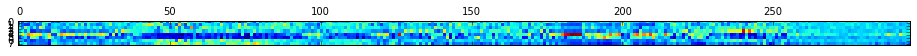

In [48]:
#the patterns look starker here than they did in the un-normed case
plt.matshow(category_means_normed)

In [49]:
prediction = [correlation_classifier(resp, 
                                     category_means_normed, 
                                     unique_categories)
                          for resp in Neural_Data_v0v3_normed]

pct = percent_correct(prediction, category_v0v3)
print('Normed Correlation classifier accuracy on 8-way classification'
      '(V0/V3): %.2f%%' % (100*pct))

#... and in fact, norming seemes to help a little (compared to ~65% from un-normed case)

Normed Correlation classifier accuracy on 8-way classification(V0/V3): 68.44%


In [50]:
#This is a faster and more general version of all the distance-based classifiers
from scipy.spatial.distance import cdist
def minimum_distance_classifier_fast(X, means, ucats, metric='euclidean'):
    """Arguments:
         X = array of examples of data -- of shape (K, N) where K = number of examples
             and N = number of neurons
         means = matrix of means of each neuron for each category, 
                 of shape (M, N), where M = number of categories
         ucats = vector of category labels (of length M)
         metric = which metric to compute based on (possibilities are described in)
             https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
       Returns: prediction for x based on minimum distance to category means for 
                requested meric
    """
    #use the cdist function to get a (K, M) distance matrix, with one row for each stimulus
    #  and one colum for each category
    dists = cdist(X, means, metric=metric) 
    #get the length-K vector of indices of minimum-distance categories
    min_dist_inds = dists.argmin(axis=1)
    #return the category predictions
    return ucats[min_dist_inds]

In [97]:
predictions = minimum_distance_classifier_fast(Neural_Data_v0v3_normed, 
                                      category_means_normed, 
                                      unique_categories,
                                      metric='correlation')

pct = percent_correct(predictions, category_v0v3)
print('Normed Correlation classifier accuracy on 8-way classification'
      '(V0/V3): %.2f%%' % (100*pct))

#see same result as before, but much faster!

Normed Correlation classifier accuracy on 8-way classification(V0/V3): 68.44%


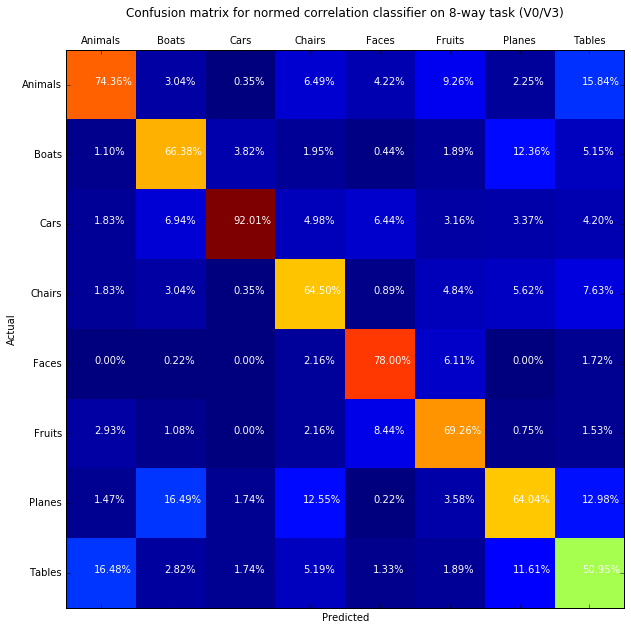

In [98]:
cmat = get_confusion_matrix(predictions, 
                            category_v0v3, 
                            unique_categories)
fig = plt.figure(figsize=(10, 10))
visualize_confmat(cmat, unique_categories, fig=fig)
plt.title('Confusion matrix for normed correlation classifier on 8-way task (V0/V3)')

## Other performance metrics

In [237]:
def dprime_from_rates(tpr, far, clip=5):
    """Computes the formula
          Z(true positive rate) - Z(false alarm rate)
        where Z = inverse of the CDF of the gaussian
    """
    posppf = np.clip(stats.norm.ppf(tpr), -clip, clip)
    negppf = np.clip(stats.norm.ppf(far), -clip, clip)
    return posppf - negppf


def dprime_binary(predicted, actual, clip=5):
    """Assumes predicted, actual binary (0, 1)-valued vectors -- 
       the positive class value is "1" while the negative class is "0"
    """
    total_positives = (actual == 1).sum()
    true_positives = ((predicted == 1) & (actual == 1)).sum()
    true_positive_rate = true_positives / float(total_positives)
    total_negatives = (actual == 0).sum()
    false_alarms = ((predicted == 1) & (actual == 0)).sum()
    false_alarm_rate = false_alarms / float(total_negatives)
    return dprime_from_rates(true_positive_rate, false_alarm_rate, clip=clip)


def confusion_matrix_stats(cmat):
    """get generalized statistics from confusion matrix
       arguments: confusion matrix of shape (M, M) where M = number of categories
                   rows are actual, columns are predicted
       returns:
          len-M vectors of 
            total positives (P)
            total negavites (N)
            true positives (TP)
            true negatives (TN)
            false positives (FP)
            false nevatives (FN)
    """
    M = cmat.shape[0]
    TP = []
    FN = []
    FP = []
    TN = []
    for i in range(M):
        tp = cmat[i, i]                  #true positives are the diagonal element
        fp = cmat[:, i].sum() - tp       #false positives are column sum - diagonal
        fn = cmat[i].sum() - tp          #false negatives are row sum - diagonal
        tn = cmat.sum() - fp - fn - tp   #true negatives are everything else
        TP.append(tp)
        FN.append(fn)
        FP.append(fp)
        TN.append(tn)
    TP = np.array(TP)
    FN = np.array(FN)
    FP = np.array(FP)
    TN = np.array(TN)
    P = TP + FN    #total positives are true positives + false negatives
    N = TN + FP    #total negatives are true negatives + false positives
    return P, N, TP, TN, FP, FN
    
    
def balanced_accuracy(confmat):
    """Computes balanced accuracy (see http://mvpa.blogspot.com/2015/12/balanced-accuracy-what-and-why.html)
       from confusion matrix 
    """
    P, N, TP, TN, FP, FN = confusion_matrix_stats(confmat)
    sensitivity = TP / P.astype(float)
    specificity = TN / N.astype(float)
    balanced_acc = (sensitivity + specificity) / 2.
    return balanced_acc
    

def dprime_confmat(cmat, clip=5):
    """Computes vector of dprimes from confusion matrix
    """
    P, N, TP, TN, FP, FN = confusion_matrix_stats(cmat)
    TPR = TP / P.astype(float)
    FPR = FP / N.astype(float)
    return dprime_from_rates(TPR, FPR, clip=clip)


def accuracy_confmat(cmat):
    correct = cmat.diagonal().sum()
    total = cmat.sum()
    return correct / float(total)

In [91]:
balanced_accuracy(cmat)

array([ 0.74125   ,  0.85482143,  0.82714286,  0.84321429,  0.92107143,
        0.88517857,  0.69660714,  0.78785714])

In [89]:
dprime_confmat(cmat)

array([ 1.9787648 ,  2.31746989,  2.81854848,  2.22571721,  2.96988777,
        2.54935674,  1.63849053,  1.76285901])

### Simple comparison of neurons from V4 and IT

In [106]:
#let's get some data
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']

IT_Neural_Data_v0v3_normed = Neural_Data_v0v3_normed[:, IT_NEURONS]
V4_Neural_Data_v0v3_normed = Neural_Data_v0v3_normed[:, V4_NEURONS]

category_means_normed_IT = category_means_normed[:, IT_NEURONS]
category_means_normed_V4 = category_means_normed[:, V4_NEURONS]

In [107]:
#Ok, how does the performance go if we only look at IT neurons?
predictions = minimum_distance_classifier_fast(IT_Neural_Data_v0v3_normed, 
                                      category_means_normed_IT, 
                                      unique_categories,
                                      metric='correlation')

pct = percent_correct(predictions, category_v0v3)
print('Normed Correlation classifier accuracy from IT on 8-way classification'
      '(V0/V3): %.2f%%' % (100*pct))

#so compared to having all 296 neurons, almost no performance drop just by looking at IT

Normed Correlation classifier accuracy from IT on 8-way classification(V0/V3): 68.53%


In [110]:
#what about V4 neurons only?
predictions = minimum_distance_classifier_fast(V4_Neural_Data_v0v3_normed, 
                                      category_means_normed_V4, 
                                      unique_categories,
                                      metric='correlation')

pct = percent_correct(predictions, category_v0v3)
print('Normed Correlation classifier accuracy from V4 on 8-way classification'
      '(V0/V3): %.2f%%' % (100*pct))

#however, looking only at V4 neurons does lead to an apparently substantial performance drop

Normed Correlation classifier accuracy from V4 on 8-way classification(V0/V3): 42.81%


In [155]:
#actually, to be fair in our comparison of IT to V4 we need to equalize the number of 
#neurons on which we build the classifiers.  There are more IT neurons in the dataset (168)
#than there are V4 neurons (128).  So let's subsampe 128 IT neurons. 
#Of course, to do this properly we should subsample a bunch of times. 

def subsample_IT_and_check_performance(K):
    fair_number_of_neurons = min(len(IT_NEURONS), len(V4_NEURONS))
    rng = np.random.RandomState(seed=0)
    pcts = []
    for sample_num in range(K):
        perm = rng.permutation(len(IT_NEURONS))
        IT_Neural_Data_v0v3_normed_subsample = IT_Neural_Data_v0v3_normed[:, 
                                                        perm[:fair_number_of_neurons]]
        category_means_normed_IT_subsample = category_means_normed_IT[:, 
                                                        perm[:fair_number_of_neurons]]

        predictions = minimum_distance_classifier_fast(IT_Neural_Data_v0v3_normed_subsample, 
                                              category_means_normed_IT_subsample, 
                                              unique_categories,
                                              metric='correlation')

        pct = percent_correct(predictions, category_v0v3)
        pcts.append(pct)
    return pcts
        
#let's do the subsampling 100 times (it's a good thing we have a fast classifier!)
pcts = subsample_IT_and_check_performance(100)
    
print('Normed Correlation classifier accuracy from %d-neuron IT subsample on '
      '8-way classification (V0/V3): %.2f%% (mean) %.2f%% (std)' % (fair_number_of_neurons, 
                                                100*np.mean(pcts),
                                                100*np.std(pcts)))

#ok, so still way better than 128 V4 neurons -- so the performance improvement in IT is probably NOT because there are more IT neurons
#in the sample.

Normed Correlation classifier accuracy from 128-neuron IT subsample on 8-way classification (V0/V3): 67.71% (mean) 0.83% (std)


In [156]:
#let's look at where the weights come from in the classifier
def weightfunc(x):
    return (x - x.mean(1)[:, np.newaxis]) / (x.std(1)[:, np.newaxis])

abs_weights = np.abs(weightfunc(category_means_normed))

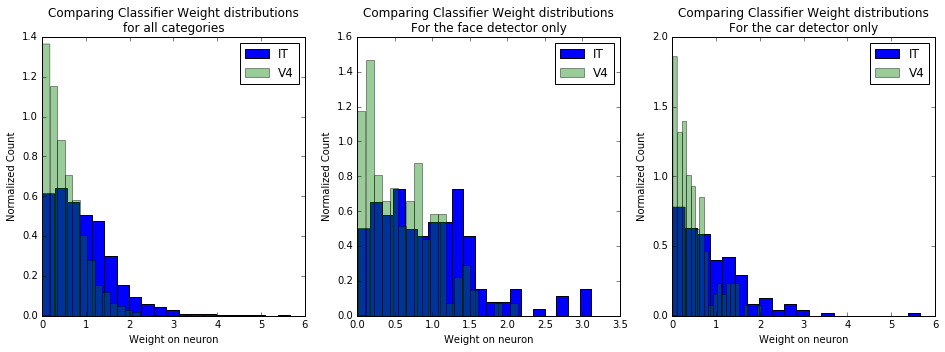

In [157]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
l0 = plt.hist(abs_weights[:, IT_NEURONS].ravel(), bins=20, normed=True)
l1 = plt.hist(abs_weights[:, V4_NEURONS].ravel(), bins=20, normed=True, alpha=.4)
plt.legend([l0[2][0], l1[2][0]], ['IT', 'V4'])
plt.title('Comparing Classifier Weight distributions\nfor all categories')
plt.xlabel('Weight on neuron')
plt.ylabel('Normalized Count')

plt.subplot(1, 3, 2)
l0 = plt.hist(abs_weights[:, IT_NEURONS][4], bins=20, normed=True)
l1 = plt.hist(abs_weights[:, V4_NEURONS][4], bins=20, normed=True, alpha=.4)
plt.legend([l0[2][0], l1[2][0]], ['IT', 'V4'])
plt.title('Comparing Classifier Weight distributions\nFor the face detector only')
plt.xlabel('Weight on neuron')
plt.ylabel('Normalized Count')

plt.subplot(1, 3, 3)
l0 = plt.hist(abs_weights[:, IT_NEURONS][2], bins=20, normed=True)
l1 = plt.hist(abs_weights[:, V4_NEURONS][2], bins=20, normed=True, alpha=.4)
plt.legend([l0[2][0], l1[2][0]], ['IT', 'V4'])
plt.title('Comparing Classifier Weight distributions\nFor the car detector only')
plt.xlabel('Weight on neuron')
plt.ylabel('Normalized Count')

#so IT units are substantially heigher weighted by the classifier

## Cross Validation

In [312]:
def get_splits(metadata,
               split_by_func,
               num_splits,
               num_per_class_test,
               num_per_class_train,
               train_filter=None,
               test_filter=None,
               seed=0):
    """
    construct a consistent set of splits for cross validation
    
    arguments: 
        metadata: numpy.rec.array of metadata 
        split_by_func: callable, returns label for spliting data into balanced categories 
                       when applied to metadata
        num_per_class_test: number of testing examples for each unique split_by category
        num_per_class_train: number of train examples for each unique split_by category
        train_filter: callable (or None): specifying which subset of the data to use in training
                       applied on a per-element basis to metadata
        test_filter: callable (or None): specifying which subset of the data to use in testing
                       applied on a per-element basis to metadata
        seed: seed for random number generator
    """
    
    #define helper function for filtering metadata by desired filter
    def get_possible_inds(metadata, filter):
        inds = np.arange(len(metadata))
        if filter is not None:
            subset = np.array(map(filter, metadata)).astype(np.bool)
            inds = inds[subset]
        return inds
    
    #filter the data by train and test filters
    train_inds = get_possible_inds(metadata, train_filter)
    test_inds = get_possible_inds(metadata, test_filter)
    
    #construct possibly category labels for balancing data
    labels = split_by_func(metadata)
    #for later convenience, get unique values of splitting labels in train and test data
    unique_train_labels = np.unique(labels[train_inds])
    unique_test_labels = np.unique(labels[test_inds])
    
    #seed the random number generator
    rng = np.random.RandomState(seed=seed)
    
    #construct the splits one by one
    splits = []
    for _split_ind in range(num_splits):
        #first construct the testing data
        actual_test_inds = []
        #for each possible test label
        for label in unique_test_labels: 
            #look at all possible stimuli with this label
            possible_test_inds_this_label = test_inds[labels[test_inds] == label]
            #count how many there are
            num_possible_test_inds_this_label = len(possible_test_inds_this_label)
            #make sure there are enough
            assert num_possible_test_inds_this_label >= num_per_class_test, 'You requested %s per test class but there are only %d available' % (num_per_class_test,
                                                                                      num_possible_test_inds_this_label)
            #select num_per_class_test random examples
            perm = rng.permutation(num_possible_test_inds_this_label)
            actual_test_inds_this_label = possible_test_inds_this_label[perm[ :num_per_class_test]]
            actual_test_inds.extend(actual_test_inds_this_label)
        actual_test_inds = np.sort(actual_test_inds)
        
        #now, since the pools of possible train and test data overlap, 
        #but since we don't want the actual train and data examples to overlap at all,
        #remove the chosen test examples for this split from the pool of possible train examples for this split
        remaining_available_train_inds = np.unique(list(set(train_inds).difference(actual_test_inds)))
        
        #now contruct the train portion of the split
        #basically the same way as for the testing examples
        actual_train_inds = []
        for label in unique_train_labels:
            _this_label = labels[remaining_available_train_inds] == label
            possible_train_inds_this_label = remaining_available_train_inds[_this_label]
            num_possible_train_inds_this_label = len(possible_train_inds_this_label)
            assert num_possible_train_inds_this_label >= num_per_class_train, 'You requested %s per train class but there are only %d available' % (num_per_class_train,
                                                                                       num_possible_train_inds_this_label)
            perm = rng.permutation(num_possible_train_inds_this_label)
            actual_train_inds_this_label = possible_train_inds_this_label[perm[ :num_per_class_train]]
            actual_train_inds.extend(actual_train_inds_this_label)
        actual_train_inds = np.sort(actual_train_inds)
        
        split = {'train': actual_train_inds, 'test': actual_test_inds}
        splits.append(split)
        
    return splits
        
    

In [198]:
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

meta_array.dtype

dtype((numpy.record, [(u'category', 'S7'), (u'object_name', 'S24'), (u'rotation_xy', '<f8'), (u'rotation_xz', '<f8'), (u'rotation_yz', '<f8'), (u'size', '<f8'), (u'translation_y', '<f8'), (u'translation_z', '<f8'), (u'variation_level', 'S2')]))

In [313]:
class MinimumDistanceClassifier(object):
    """
    Codification of generic minimum distance classifier in a scikit-learn friendly format.
    """
    def __init__(self, labelset, n_features, fnorm=False, metric='correlation'):
        """
        Arguments: 
            labelset -- list of unique values the classifier can have
            n_features -- how many features will be trained/tested
            fnorm -- whether to do featurewise normalization or not
            metric -- what distance metric to use (consistent with scipy.spatial.distance.cdist)
        """
        assert labelset.ndim == 1, 'The labelset can only have one dimension'
        assert len(labelset) == len(np.unique(labelset)), 'The labelset must be a unique list of elements'
        self.labelset = labelset
        self.n_classes = len(labelset)
        self.n_features = n_features
        self.fnorm = fnorm
        self.metric = metric

    def initialize(self, val=None, n=None):
        self._mu = np.zeros((self.n_classes, self.n_features))
        self._n_samples = np.zeros((self.n_classes,)).astype(np.int)
        if val is not None:
            assert val.shape == self.mu.shape
            assert n.dtype == self._n_samples.dtype
            assert n.shape == self._n_samples.shape
            assert (n >= 0).all()
            self._mu += val
            self._n_samples += n

    def fit(self, X, y):
        self.initialize(val=None, n=None)
        if self.fnorm:
            self.fmean = X.mean(axis=0)
            X = X - self.fmean
            self.fvar = X.std(axis=0)
            X = X / np.maximum(self.fvar, 1e-6)
        self.partial_fit(X, y)

    def partial_fit(self, X, y, safe=True):
        assert X.ndim == 2
        assert y.ndim == 1
        assert X.shape == (len(y), self.n_features), (X.shape, (len(y), self.n_features))
        assert set(y) <= set(self.labelset), (set(y), set(self.labelset))
        if safe:
            uy = np.unique(y)
            assert (uy == self.labelset).all()
        for vi, v in enumerate(self.labelset):
            Xv = X[y == v]
            nv = float(Xv.shape[0])
            if nv > 0:
                Xvm = Xv.mean(0)
                ns = self._n_samples[vi]
                self._mu[vi] = (ns / (ns + nv)) * self._mu[vi] + (nv / (ns + nv)) * Xvm
                self._n_samples[vi] += int(nv)

    @property
    def coef_(self):
        c = self._mu
        return c

    @property
    def weights(self):
        c = self.coef_
        def weightfunc(x):
            return (x - x.mean(1)[:, np.newaxis]) / (x.std(1)[:, np.newaxis])
        return weightfunc(c)

    def decision_function(self, X):
        if self.fnorm:
            X = X - self.fmean
            X = X / np.maximum(self.fvar, 1e-6)
        return cdist(X, self.coef_, metric=self.metric)

    def predict(self, X):
        assert X.ndim == 2
        assert X.shape[1] == self.n_features
        decs = self.decision_function(X)
        return self.labelset[decs.argmin(1)]

In [314]:
def evaluate_results(confmats, labels):
    """Convenience function that summarize results over confusion matrices
       Arguments:
           confmats = array of shape (M, M, ns)  where M = number of categories
                      and ns = number of splits
                confmats[i, j, k] = number of times classifier predicted class j 
                                    when actual is class i, on split k 
           labels = length-M vector of category labels
           
       Returns: dictionary with useful summary metrics, including dprime,
                balanced accuracy, and percent correct (regular "accuracy")
                both for the split-mean confusion matrix, and separately across splits
                  
    """
    result = {}
    result['labels'] = labels
    result['confusion_matrices'] = confmats
    mean_confmat = confmats.mean(0)
    result['mean_dprime'] = dprime_confmat(mean_confmat)
    result['mean_balanced_accuracy'] = balanced_accuracy(mean_confmat)
    result['mean_accuracy'] = accuracy_confmat(mean_confmat)
    
    result['dprime_by_split'] = [dprime_confmat(c) for c in confmats]
    result['balanced_acc_by_split'] = [balanced_accuracy(c) for c in confmats]
    result['accuracy_by_split'] = [accuracy_confmat(c) for c in confmats]
    
    return result    
    
    
def train_and_test_correlation_classifier(features, labels, splits):
    """Routine for contructing, training and testing correlation classifier
       
       Arguments: 
           features: (K, M) feature array where K = number of stimuli and M = number of features
           labels: length-K vector of labels to be predicted
           splits: splits of data (constructed by calling the get_splits function)
           
       Returns:
           dictionary summary of training and testing results
    
    """
    ucats = np.unique(labels)
    train_confmats = []
    test_confmats = []
    for split in splits:
        model = MinimumDistanceClassifier(ucats,
                                          features.shape[1],
                                          fnorm=True,
                                          metric='correlation')
        
        train_inds = split['train']
        test_inds = split['test']
        
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        model.fit(train_features, train_labels)
        
        train_predictions = model.predict(train_features)
        train_confmat = get_confusion_matrix(train_predictions, train_labels, ucats)
        train_confmats.append(train_confmat)
        
        test_features = features[test_inds]
        test_labels = labels[test_inds]
        
        test_predictions = model.predict(test_features)
        test_confmat = get_confusion_matrix(test_predictions, test_labels, ucats)
        test_confmats.append(test_confmat)
        
    train_confmats = np.array(train_confmats)
    train_results = evaluate_results(train_confmats, ucats)
    test_confmats = np.array(test_confmats)
    test_results = evaluate_results(test_confmats, ucats)
    results = {'train': train_results, 'test': test_results}
    return results
        

In [317]:
#OK let's test out our new machinery 
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

splits = get_splits(meta_array, 
                    lambda x: x['object_name'],  #we're balancing splits by object
                    10,  #10 total splits
                    20,  #with 20 testing 
                    20,  #and 20 trainin examples per object
                    train_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #keeping on V3 and V6 stimuli in training
                    test_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #in testing too
                   )

results_V4 = train_and_test_correlation_classifier(V4_Neural_Data, meta_array['category'], splits)
results_IT = train_and_test_correlation_classifier(IT_Neural_Data, meta_array['category'], splits)

print('Average test accuracy of V4 on 8-way categorization (V3 & V6) is %.2f%%' % (100*results_V4['test']['mean_accuracy']))
print('Average test accuracy of IT on 8-way categorization (V3 & V6) is %.2f%%' % (100*results_IT['test']['mean_accuracy']))

Average test accuracy of V4 on 8-way categorization (V3 & V6) is 28.19%
Average test accuracy of IT on 8-way categorization (V3 & V6) is 55.04%


In [299]:
#Ok let's flex our muscles a little and compute a training curve as a function of 
#number of training examples

train_curve_points = [2, 5, 10, 15, 20, 30, 40, 50, 60, 80, 160, 240, 320, 400, 480]
def get_category_training_curve(features):
    results = []
    for num_train in train_curve_points:
        splits = get_splits(meta_array, 
                    lambda x: x['category'], #now we're going to construct splits by *category* rather than object
                    20,  #20 splits each time
                    20 * 8,   #total of 20*8 = 160 testing examples per category
                    num_train,  #here's where the variable number of training examples comes in
                    train_filter=lambda x: x['variation_level'] in ['V3', 'V6'], #same filters as above
                    test_filter=lambda x: x['variation_level'] in ['V3', 'V6'])
        result = train_and_test_correlation_classifier(features, meta_array['category'], splits)
        results.append(result)
    return results

V4_curve = get_category_training_curve(V4_Neural_Data)
IT_curve = get_category_training_curve(IT_Neural_Data)

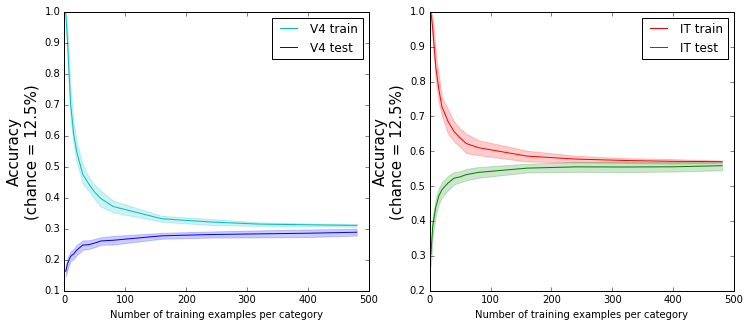

In [310]:
#Let's plot our results.
def plot_training_curve(curve_data, color1, color2):
    train_means = np.array([np.mean(r['train']['accuracy_by_split']) for r in curve_data])
    train_stds = np.array([np.std(r['train']['accuracy_by_split']) for r in curve_data])
    test_means = np.array([np.mean(r['test']['accuracy_by_split']) for r in curve_data])
    test_stds = np.array([np.std(r['test']['accuracy_by_split']) for r in curve_data])

    l1 = plt.plot(train_curve_points, train_means, color=color1)
    plt.fill_between(train_curve_points, 
                     train_means - train_stds, 
                     train_means + train_stds, 
                     color=color1,
                     alpha = 0.2)
    l2 = plt.plot(train_curve_points, test_means, color=color2)
    plt.fill_between(train_curve_points, 
                     test_means - test_stds, 
                     test_means + test_stds, 
                     color=color2,
                     alpha = 0.2)
    plt.xlabel('Number of training examples per category')
    plt.ylabel('Accuracy\n(chance = 12.5%)', fontsize=15)
    return l1, l2
    
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
l0, l1 = plot_training_curve(V4_curve, 'c', 'b')
plt.legend([l0[0], l1[0]], ['V4 train', 'V4 test'])
plt.subplot(1, 2, 2)
l2, l3 = plot_training_curve(IT_curve, 'r', 'g')
plt.legend([l2[0], l3[0]], ['IT train', 'IT test'])

#ok, we're seeing: several interesting things:
#   (1) both IT and V4 have fast-increasing training curves.  Don't need that many examples 
#       to approach final performace
#   (2) IT >> V4 -- we knew that already
#   (3) You can see the strong signs of overfitting with small numbers of training examples
#       ... that is, where train performance > test performance.  Increasing the number of
#       training examples both increases test performance, but *decreases* train performance
#       to the point where they meet (e.g. no overfitting is occuring)

## Optimal binary threshold in the general case

In [331]:
def a_func(sig1, sig2):
    return (1. / (sig2**2)) - (1. / (sig1**2))

def b_func(mu1, sig1, mu2, sig2):
    return 2 * ((mu1 / sig1**2) - (mu2 / sig2**2))

def c_func(mu1, sig1, mu2, sig2, f):
    first_term = (mu2 / sig2)**2 - (mu1 / sig1)**2
    second_term = 2 * np.log((sig1 / sig2) * ((1-f) / f))
    return first_term - second_term

def get_optimal_threshold(mu1, sig1, mu2, sig2, f):
    a = a_func(sig1, sig2)
    b = b_func(mu1, sig1, mu2, sig2)
    c = c_func(mu1, sig1, mu2, sig2, f)
    numerator1 = -b + np.sqrt(b**2 - 4 * a * c)
    numerator2 = -b - np.sqrt(b**2 - 4 * a * c)
    denominator = 2 * a
    val1 = numerator1 / denominator
    val2 = numerator2 / denominator
    return val1, val2

In [423]:
mu1 = most_corred_resp[face_or_not_v0v3].mean()
sig1 = most_corred_resp[face_or_not_v0v3].std()
mu2 = most_corred_resp[np.invert(face_or_not_v0v3)].mean()
sig2 = most_corred_resp[np.invert(face_or_not_v0v3)].std()
f = face_or_not_v0v3.sum() / float(len(face_or_not_v0v3))
get_optimal_threshold(mu1, sig1, mu2, sig2, f)

(0.30534944459606522, -1.3698342605321248)

In [333]:
mu1 = tenthmost_corred_resp[face_or_not_v0v3].mean()
sig1 = tenthmost_corred_resp[face_or_not_v0v3].std()
mu2 = tenthmost_corred_resp[np.invert(face_or_not_v0v3)].mean()
sig2 = tenthmost_corred_resp[np.invert(face_or_not_v0v3)].std()
f = face_or_not_v0v3.sum() / float(len(face_or_not_v0v3))
get_optimal_threshold(mu1, sig1, mu2, sig2, f)

(1.5825568889100552, -4.5589096426776736)

In [334]:
mu2 = best_neg_corred_resp[face_or_not_v0v3].mean()
sig2 = best_neg_corred_resp[face_or_not_v0v3].std()
mu1 = best_neg_corred_resp[np.invert(face_or_not_v0v3)].mean()
sig1 = best_neg_corred_resp[np.invert(face_or_not_v0v3)].std()
f = 1 - face_or_not_v0v3.sum() / float(len(face_or_not_v0v3))
get_optimal_threshold(mu1, sig1, mu2, sig2, f)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in sqrt


(nan, nan)

In [ ]:
def sensitivity(data, is_signal):
    data_s = data[is_signal]
    data_n = data[np.invert(is_signal)]
    data_smean = data_s.mean()
    data_nmean = data_n.mean()
    data_sstd = data_s.std()
    data_nstd = data_n.std()
    
    numerator = data_smean - data_nmean
    denominator = np.sqrt(0.5 * (data_sstd**2 + data_nstd**2))
    return numerator / denominator
    

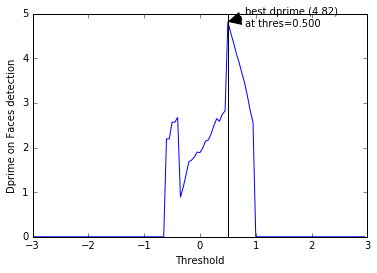

In [655]:
def plot_threshold_dprime(resp, categories, target):
    threshold_series = np.arange(-3, 3, .05)
    dprimes = [dprime_binary(resp > t, categories) 
                        for t in threshold_series]
    best_thres_ind = np.argmax(dprimes)
    best_thres = threshold_series[best_thres_ind]
    best_acc = dprimes[best_thres_ind]
    plt.plot(threshold_series, dprimes)
    plt.axvline(best_thres, color='k')
    plt.xlabel('Threshold')
    plt.ylabel('Dprime on %s detection' % target)
    plt.annotate('best dprime (%.2f)\nat thres=%.3f' % (best_acc, best_thres),
                 xy=(best_thres, best_acc), 
                 xytext=(best_thres + .3, best_acc - .1),
                arrowprops=dict(facecolor='black', shrink=0.05),
                )
    
most_corred_resp = Neural_Data_subset[:, best_ind_facevscar]
plot_threshold_dprime(most_corred_resp, category_subset, 'Faces')